<a href="https://colab.research.google.com/github/arniery/thesis/blob/main/inference3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- Setup ---
!git clone https://github.com/auspicious3000/autovc.git
!git clone https://github.com/jik876/hifi-gan.git
!mkdir -p mel_files wav_files

!pip install -r autovc/requirements.txt
!pip install -r hifi-gan/requirements.txt
!pip install gdown librosa soundfile

Cloning into 'autovc'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 116 (delta 4), reused 9 (delta 4), pack-reused 104 (from 1)
Receiving objects: 100% (116/116), 8.18 MiB | 12.91 MiB/s, done.
Resolving deltas: 100% (29/29), done.
Cloning into 'hifi-gan'...
remote: Enumerating objects: 48, done.
remote: Total 48 (delta 0), reused 0 (delta 0), pack-reused 48 (from 1)
Receiving objects: 100% (48/48), 620.94 KiB | 2.10 MiB/s, done.
Resolving deltas: 100% (20/20), done.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'autovc/requirements.txt'
ERROR: Could not find a version that satisfies the requirement torch==1.4.0 (from versions: 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0, 2.7.0, 2.7.1, 2.8.0)
ERROR: No matching distribution found for torch==1.4.0


In [2]:
!pip install --upgrade --no-deps librosa
!pip install resampy numba soundfile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 49.2 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp /content/drive/MyDrive/autovc_data/autovc.ckpt ./
!cp -r /content/drive/MyDrive/autovc_data/wav16k ./
# !cp -r /content/drive/MyDrive/spmel ./

In [16]:
!rm -rf spmel

In [5]:
%cd /content
!mkdir spmel

/content


remember to modify autovc's make_spect.py to comment out the noise addition (wav =) and normalisation (S =) lines

In [6]:
import os
import shutil
import numpy as np
import soundfile as sf
from scipy import signal
from scipy.signal import get_window
from librosa.filters import mel # Explicitly import mel here
from numpy.random import RandomState # Import RandomState

# --- Include definitions from make_spect.py (copy these from your script) ---
# Make sure these are correctly copied from your actual make_spect.py
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

# Assuming these are the values used in your make_spect.py
b, a = butter_highpass(30, 16000, order=5)

def pySTFT(x, fft_length=1024, hop_length=256):

    x = np.pad(x, int(fft_length//2), mode='reflect')

    noverlap = fft_length - hop_length
    shape = x.shape[:-1]+((x.shape[-1]-noverlap)//hop_length, fft_length)
    strides = x.strides[:-1]+(hop_length*x.strides[-1], x.strides[-1])
    # Corrected typo: stride_techniques -> stride_tricks
    result = np.lib.stride_tricks.as_strided(x, shape=shape,
                                             strides=strides)

    fft_window = get_window('hann', fft_length, fftbins=True)
    result = np.fft.rfft(fft_window * result, n=fft_length).T

    return np.abs(result)

# Definition of mel_basis and min_level from make_spect.py
# Ensure these parameters match your training setup
sr = 16000
n_fft = 1024
fmin = 90
fmax = 7600
n_mels = 80

mel_basis = mel(sr=sr, n_fft=n_fft, fmin=fmin, fmax=fmax, n_mels=n_mels).T
min_level = np.exp(-100 / 20 * np.log(10))
# --- End of included definitions ---


# Define the paths
autovc_dir = "/content/autovc"
wav_data_dir = "/content/wav16k/female_speaker"
mel_output_dir = "/content/spmel/female_speaker" # Ensure this directory exists

# Create symbolic links in the autovc directory
# Remove existing links or directories if they exist
wavs_link_path = os.path.join(autovc_dir, 'wavs')
spmel_link_path = os.path.join(autovc_dir, 'spmel')

if os.path.exists(wavs_link_path):
    if os.path.islink(wavs_link_path):
        os.unlink(wavs_link_path)
    else:
        # If it's a directory but not a link, remove the directory and its contents
        shutil.rmtree(wavs_link_path)

if os.path.exists(spmel_link_path):
    if os.path.islink(spmel_link_path):
        os.unlink(spmel_link_path)
    else:
        # If it's a directory but not a link, remove the directory and its contents
        shutil.rmtree(spmel_link_path)


os.symlink(wav_data_dir, os.path.join(autovc_dir, 'wavs'))
os.symlink(mel_output_dir, os.path.join(autovc_dir, 'spmel'))

print(f"Created symbolic link: {os.path.join(autovc_dir, 'wavs')} -> {wav_data_dir}")
print(f"Created symbolic link: {os.path.join(autovc_dir, 'spmel')} -> {mel_output_dir}")

# Change to the autovc directory to run the script
os.chdir(autovc_dir)

# --- Modified make_spect.py logic ---
# audio file directory
rootDir = './wavs'
# spectrogram directory
targetDir = './spmel'

dirName, subdirList, fileList = next(os.walk(rootDir))
print('Found directory: %s' % dirName)

# Check if there are subdirectories
if subdirList:
    # Process files within subdirectories (original logic)
    for subdir in sorted(subdirList):
        print(f"Processing subdirectory: {subdir}")
        # Ensure the target subdirectory exists
        target_subdir = os.path.join(targetDir, subdir)
        if not os.path.exists(target_subdir):
            os.makedirs(target_subdir)

        _, _, fileList = next(os.walk(os.path.join(dirName, subdir)))
        # NOTE: Assuming subdir names can be converted to integers for RandomState seed
        prng = RandomState(int(subdir[1:])) # Adjust if your subdir names are different

        for fileName in sorted(fileList):
            if fileName.endswith('.wav'): # Process only wav files
                wav_path = os.path.join(dirName, subdir, fileName)
                # Read audio file
                x, fs = sf.read(wav_path)
                # Remove drifting noise
                y = signal.filtfilt(b, a, x)
                # Ddd a little random noise for model roubstness (commented out)
                # wav = y * 0.96 + (prng.rand(y.shape[0])-0.5)*1e-06
                # Compute spect
                D = pySTFT(y).T
                # Convert to mel and normalize
                D_mel = np.dot(D, mel_basis)
                D_db = 20 * np.log10(np.maximum(min_level, D_mel)) - 16
                S = np.clip((D_db + 100) / 100, 0, 1)
                # save spect
                output_path = os.path.join(target_subdir, fileName[:-4])
                np.save(output_path, S.astype(np.float32), allow_pickle=False)
                print(f"Saved {output_path}.npy")

else:
    # Process files directly in the root directory
    print("No subdirectories found. Processing files directly in the root directory.")
    # Ensure the target directory exists for direct files
    if not os.path.exists(targetDir):
        os.makedirs(targetDir)

    # prng = RandomState(0) # You might need a fixed seed if processing root directly, or derive from filename if applicable

    for fileName in sorted(fileList):
         if fileName.endswith('.wav'): # Process only wav files
            wav_path = os.path.join(dirName, fileName)
            # Read audio file
            x, fs = sf.read(wav_path)
            # Remove drifting noise
            y = signal.filtfilt(b, a, x)
            # Ddd a little random noise for model roubstness (commented out)
            # wav = y * 0.96 + (prng.rand(y.shape[0])-0.5)*1e-06 # prng might not be defined here

            # Compute spect
            D = pySTFT(y).T
            # Convert to mel and normalize
            D_mel = np.dot(D, mel_basis)
            D_db = 20 * np.log10(np.maximum(min_level, D_mel)) - 16
            S = np.clip((D_db + 100) / 100, 0, 1)
            # save spect
            output_path = os.path.join(targetDir, fileName[:-4])
            np.save(output_path, S.astype(np.float32), allow_pickle=False)
            print(f"Saved {output_path}.npy")

# Change back to the original working directory (optional, but good practice)
# os.chdir("/content") # Or your preferred directory

Streaming output truncated to the last 5000 lines.
Saved ./spmel/train_hindifullfemale_01549_16k.npy
Saved ./spmel/train_hindifullfemale_01550_16k.npy
Saved ./spmel/train_hindifullfemale_01551_16k.npy
Saved ./spmel/train_hindifullfemale_01552_16k.npy
Saved ./spmel/train_hindifullfemale_01553_16k.npy
Saved ./spmel/train_hindifullfemale_01554_16k.npy
Saved ./spmel/train_hindifullfemale_01555_16k.npy
Saved ./spmel/train_hindifullfemale_01556_16k.npy
Saved ./spmel/train_hindifullfemale_01557_16k.npy
Saved ./spmel/train_hindifullfemale_01558_16k.npy
Saved ./spmel/train_hindifullfemale_01559_16k.npy
Saved ./spmel/train_hindifullfemale_01560_16k.npy
Saved ./spmel/train_hindifullfemale_01561_16k.npy
Saved ./spmel/train_hindifullfemale_01562_16k.npy
Saved ./spmel/train_hindifullfemale_01563_16k.npy
Saved ./spmel/train_hindifullfemale_01564_16k.npy
Saved ./spmel/train_hindifullfemale_01565_16k.npy
Saved ./spmel/train_hindifullfemale_01566_16k.npy
Saved ./spmel/train_hindifullfemale_01567_16k.npy

In [ ]:
!cp -r "/content/spmel" "/content/drive/MyDrive"

### retrain hifigan

In [7]:
import os
import random

# Set seed for reproducibility
random.seed(42)

# Path to your wavs
wav_root = '/content/wav16k/female_speaker'
filelist_dir = '/content/hifi-gan/filelists'
train_file = os.path.join(filelist_dir, 'training.txt')
val_file = os.path.join(filelist_dir, 'validation.txt')

lines = []

# Collect all wav files
for fname in sorted(os.listdir(wav_root)):
    if fname.endswith('.wav'):
        wav_path = os.path.join(wav_root, fname)
        lines.append(wav_path)

# Shuffle and split (95% train, 5% validation)
random.shuffle(lines)
split_idx = int(0.95 * len(lines))
train_lines = lines[:split_idx]
val_lines = lines[split_idx:]

# Write to file
os.makedirs(filelist_dir, exist_ok=True)

with open(train_file, 'w') as f:
    f.write('\n'.join(train_lines))

with open(val_file, 'w') as f:
    f.write('\n'.join(val_lines))

print(f"Training file saved to: {train_file}, total: {len(train_lines)}")
print(f"Validation file saved to: {val_file}, total: {len(val_lines)}")


Training file saved to: /content/hifi-gan/filelists/training.txt, total: 6223
Validation file saved to: /content/hifi-gan/filelists/validation.txt, total: 328


In [8]:
import json

flat_config = {
  "batch_size": 32,                # Double your current batch size if GPU memory allows
  "learning_rate": 0.0002,
  "adam_b1": 0.8,
  "adam_b2": 0.99,
  "lr_decay": 0.999,
  "seed": 1234,
  "fp16_run": True,                # Enable mixed-precision for faster training
  "sampling_rate": 16000,
  "segment_size": 4096,            # Smaller segments = faster per-step computation
  "filter_length": 1024,
  "hop_size": 256,
  "win_size": 1024,
  "n_fft": 1024,
  "num_mels": 80,
  "fmin": 90,
  "fmax": 7600,
  "fmax_for_loss": None,
  "upsample_rates": [8, 8, 2, 2],
  "upsample_kernel_sizes": [16, 16, 4, 4],
  "upsample_initial_channel": 512,
  "resblock": "1",
  "resblock_kernel_sizes": [3, 7, 11],
  "resblock_dilation_sizes": [[1, 3, 5], [1, 3, 5], [1, 3, 5]],
  "resblock_initial_channel": 256,
  "num_workers": 4,                # DataLoader workers
  "num_gpus": 1,
  "dist_config": {
    "dist_backend": "nccl",
    "dist_url": "tcp://localhost:54321",
    "world_size": 1
  }
}

with open("/content/hifi-gan/config_autovc.json", "w") as f:
    json.dump(flat_config, f, indent=4)

print("Flat config saved to /content/hifi-gan/config_autovc.json")

Flat config saved to /content/hifi-gan/config_autovc.json


train hifigan here + copy paste train.py and meldataset.py

In [16]:
# fine-tuning
%cd /content/hifi-gan

!python train.py \
  --input_wavs_dir /content/wav16k/female_speaker \
  --input_mels_dir "" \
  --input_training_file /content/hifi-gan/filelists/training.txt \
  --input_validation_file /content/hifi-gan/filelists/validation.txt \
  --checkpoint_path /content/hifi-gan/cp_hifigan \
  --config config_autovc.json \
  --training_epochs 12

/content/hifi-gan
2025-08-22 01:52:58.783124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755827578.803370   21961 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755827578.809712   21961 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755827578.825773   21961 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755827578.825799   21961 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755827578.825803   21961 computation_placer.cc:177] comp

In [9]:
!pip install gtts

from gtts import gTTS
import os

os.makedirs('source_wavs', exist_ok=True)

texts = ["Hello, this is a test.", "AutoVC makes voice conversion fun!", "We are testing multiple files."]

for i, text in enumerate(texts, 1):
    tts = gTTS(text=text, lang='en')
    file_path = f'source_wavs/speech{i}.wav'
    tts.save(file_path)
    print(f"Saved {file_path}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 9.2 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.2.1
    Uninstalling click-8.2.1:
      Successfully uninstalled click-8.2.1
Saved source_wavs/speech1.wav
Saved source_wavs/speech2.wav
Saved source_wavs/speech3.wav


In [ ]:
!ls autovc/

conversion.ipynb  main.py	    model_bl.py  solver_encoder.py
data_loader.py	  make_metadata.py  model_vc.py  synthesis.py
hparams.py	  make_spect.py     README.md	 vocoder.ipynb
LICENSE		  metadata.pkl	    results.pkl  wavs


In [10]:
import torch, torch.nn.functional as F
import numpy as np, librosa

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Match typical AutoVC/HiFi-GAN settings used in many repos
SR = 16000
N_FFT = 1024
HOP = 256
WIN = 1024
N_MELS = 80
LOG_OFFSET = 1e-6   # small stabilizer for log

def wav_to_logmel(wav_path):
    """Load wav -> log-mel (T, 80) as torch.FloatTensor on device."""
    wav, sr = librosa.load(wav_path, sr=SR)
    mel = librosa.feature.melspectrogram(
        y=wav, sr=SR, n_fft=N_FFT, hop_length=HOP, win_length=WIN,
        n_mels=N_MELS, power=1.0
    )
    # mel = np.log(np.maximum(mel, LOG_OFFSET))         # (80, T)
    mel = torch.from_numpy(mel.T).float().to(device)  # (T, 80) time-first for D_VECTOR
    return mel

def crop_len(T, needed):
    """Pick a random crop [left:left+needed] from length T (repeat-pad if too short)."""
    if T < needed:
        # pad by repeating the last frame (simple + keeps dtype/device)
        pad = torch.repeat_interleave
        return 0
    left = np.random.randint(0, T - needed + 1)
    return left

# ---- D_VECTOR loader & emb extraction (mirrors make_metadata.py) ----
from autovc.model_bl import D_VECTOR  # uses dim_input=80, dim_cell=768, dim_emb=256 (as in your metadata script)

def load_speaker_encoder(ckpt_path='/content/3000000-BL.ckpt'):
    C = D_VECTOR(dim_input=80, dim_cell=768, dim_emb=256).eval().to(device)
    c_checkpoint = torch.load(ckpt_path, map_location=device)
    # your metadata script strips a "module." prefix (key[7:])
    new_state_dict = {k[7:]: v for k, v in c_checkpoint['model_b'].items()}
    C.load_state_dict(new_state_dict)
    return C

def emb_from_mel(mel_T80, C, num_uttrs=10, len_crop=128):
    """
    Average embeddings over random crops, exactly like make_metadata.py
    mel_T80: (T,80) on device
    returns tensor (1,256) on device (float)
    """
    T = mel_T80.size(0)
    embs = []
    for _ in range(num_uttrs):
        if T < len_crop:
            # if too short, just tile the sequence
            reps = int(np.ceil(len_crop / T))
            mel_long = mel_T80.repeat(reps, 1)[:len_crop, :]
            crop = mel_long.unsqueeze(0)  # (1, len_crop, 80)
        else:
            left = crop_len(T, len_crop)
            crop = mel_T80[left:left+len_crop, :].unsqueeze(0)  # (1, len_crop, 80)
        with torch.no_grad():
            emb = C(crop).squeeze(0)  # (256,)
        embs.append(emb)
    emb_avg = torch.stack(embs, dim=0).mean(dim=0)  # (256,)
    return emb_avg.unsqueeze(0)  # (1,256)

In [11]:
from autovc.model_vc import Generator

# Must match your training hparams; these are common defaults in many AutoVC forks
DIM_NECK = 32
DIM_EMB  = 256
DIM_PRE  = 512
FREQ     = 16

# Load AutoVC
G = Generator(dim_neck=DIM_NECK, dim_emb=DIM_EMB, dim_pre=DIM_PRE, freq=FREQ).to(device)
ckpt = torch.load('/content/autovc.ckpt', map_location='cpu')
G.load_state_dict(ckpt['model'])
G.eval()

# Load speaker encoder (BL)
C = load_speaker_encoder('/content/3000000-BL.ckpt')


### extract and save target embedding

In [12]:
import torch

# Reference wav → log-mel
ref_mel_T80 = wav_to_logmel('/content/wav16k/female_speaker/train_hindifullfemale_00046_16k.wav')

# Extract target embedding (shape: (1,256))
c_trg = emb_from_mel(ref_mel_T80, C, num_uttrs=10, len_crop=128)

# Save to disk
torch.save(c_trg, "target_emb.pt")
print("Saved target embedding to target_emb.pt, shape:", c_trg.shape)

Saved target embedding to target_emb.pt, shape: torch.Size([1, 256])


### 4) Batch convert all source WAVs → save mels for HiFi-GAN

In [18]:
# ---------------- Step 4: AutoVC conversion ----------------
import os
import numpy as np
import torch

src_wav_dir = "/content/source_wavs"   # your source speaker wavs
out_mel_dir = "/content/mel_files"
os.makedirs(out_mel_dir, exist_ok=True)

# Load target embedding
c_trg = torch.load("/content/target_emb.pt").to(device)  # shape (1, 256)
print("Loaded target embedding, shape:", c_trg.shape)

# Process each wav
for fname in os.listdir(src_wav_dir):
    if not fname.endswith(".wav"):
        continue

    wav_path = os.path.join(src_wav_dir, fname)

    # Source wav -> log-mel (T, 80)
    src_mel = wav_to_logmel(wav_path)
    x = src_mel.unsqueeze(0) # (1, T, 80)

    # Pad the input mel spectrogram to be a multiple of FREQ
    T = x.size(1)
    if T % FREQ != 0:
        pad_size = FREQ - (T % FREQ)
        x = torch.nn.functional.pad(x, (0, 0, 0, pad_size))
        print(f"Padded {fname}: original length {T}, padded length {x.size(1)}")


    # Dummy c_org (ignored, same shape as c_trg)
    c_org = torch.zeros_like(c_trg)

    with torch.no_grad():
        mel_out, mel_out_postnet, _ = G(x, c_org, c_trg)

    # Save mel for HiFi-GAN: (T, 80)
    # Remove the padding added earlier before saving
    mel_converted = mel_out_postnet.squeeze(0).squeeze(0).cpu().numpy()[:T, :]


    # --- Normalize mel to expected HiFi-GAN training range (0 to ~1) ---
    # Assuming your training data is in the range [min_train_mel, max_train_mel]
    # You might need to adjust these values based on your actual training data range
    # Based on the test cell, the training mel range is ~[0.0, 0.96]
    min_train_mel = 0.0
    max_train_mel = 0.96 # Use a value slightly higher than the observed max if needed

    mel_min, mel_max = mel_converted.min(), mel_converted.max()
    # Scale the mel values to be between 0 and 1 based on their *current* range
    mel_normalized_0_1 = (mel_converted - mel_min) / (mel_max - mel_min)
    # Then scale and shift to the target training range
    mel_converted_normalized = mel_normalized_0_1 * (max_train_mel - min_train_mel) + min_train_mel


    out_path = os.path.join(out_mel_dir, fname.replace(".wav", ".npy"))
    np.save(out_path, mel_converted_normalized)
    print(f"Saved {out_path}")

Loaded target embedding, shape: torch.Size([1, 256])
Padded speech2.wav: original length 202, padded length 208
Saved /content/mel_files/speech2.npy
Padded speech1.wav: original length 137, padded length 144
Saved /content/mel_files/speech1.npy
Padded speech3.wav: original length 169, padded length 176
Saved /content/mel_files/speech3.npy


Loaded .npy mel shape: (137, 80)
Min/Max values: 0.0 0.96
Transposed mel -> new shape: (80, 137)


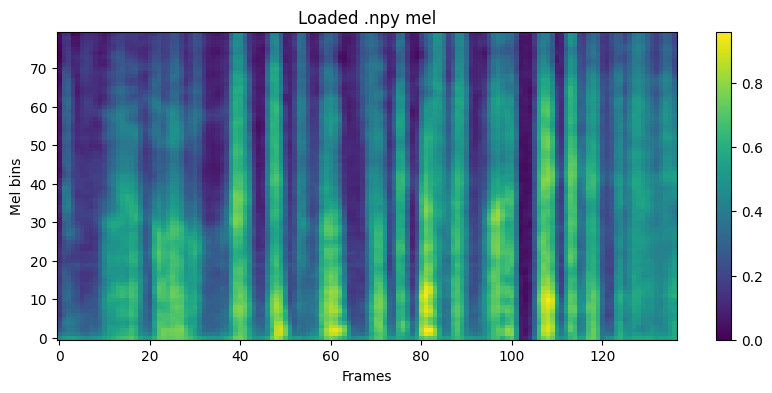

In [25]:
# --------- Load an .npy mel (from AutoVC or preprocessing) ---------
mel = np.load("/content/mel_files/speech1.npy")

print("Loaded .npy mel shape:", mel.shape)
print("Min/Max values:", mel.min(), mel.max())

# Ensure mel shape is (num_mels, T)
if mel.shape[0] != num_mels and mel.shape[1] == num_mels:
    mel = mel.T
    print("Transposed mel -> new shape:", mel.shape)

# Plot the .npy mel
plt.figure(figsize=(10,4))
plt.imshow(mel, aspect="auto", origin="lower", interpolation="none")
plt.colorbar()
plt.title("Loaded .npy mel")
plt.xlabel("Frames")
plt.ylabel("Mel bins")
plt.show()

In [27]:
import gdown
dl = {'/content/hifi-gan/config.json': 'https://drive.google.com/u/1/uc?id=1aDh576AEYA5eTjhx7sew1qcCM_Y526jc&export=download',
      '/content/hifi-gan/generator_v1': 'https://drive.google.com/u/1/uc?id=14NENd4equCBLyyCSke114Mv6YR_j_uFs&export=download'}
for k in dl:
    gdown.download(dl[k], k)

Downloading...
From: https://drive.google.com/u/1/uc?id=1aDh576AEYA5eTjhx7sew1qcCM_Y526jc&export=download
To: /content/hifi-gan/config.json
100%|██████████| 795/795 [00:00<00:00, 2.00MB/s]
Downloading...
From: https://drive.google.com/u/1/uc?id=14NENd4equCBLyyCSke114Mv6YR_j_uFs&export=download
To: /content/hifi-gan/generator_v1
100%|██████████| 55.8M/55.8M [00:01<00:00, 43.1MB/s]


### 5) hifigan inference

In [45]:
!mkdir mel_test/

In [46]:
%cd hifi-gan
!python3 /content/hifi-gan/inference_e2e.py --checkpoint_file /content/hifi-gan/generator_v1 --input_mels_dir ../mel_test/ --output_dir ../converted_wavs/
%cd ../

/content/hifi-gan
Initializing Inference Process..
/usr/local/lib/python3.12/dist-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
Loading '/content/hifi-gan/generator_v1'
Complete.
Removing weight norm...
../converted_wavs/test_generated_e2e.wav
/content


In [42]:
# ---------------- Step 5: HiFi-GAN inference ----------------
import os
import torch
import numpy as np
import soundfile as sf
from types import SimpleNamespace
import importlib.util
import sys

# --- Set paths ---
hifigan_dir = "/content/hifi-gan"   # folder containing models.py
checkpoint_path = "/content/hifi-gan/generator_v1"
mel_dir = "/content/spmel/female_speaker/train_hindifullfemale_00005_16k.npy"
wav_out_dir = "/content/converted_wavs"
os.makedirs(wav_out_dir, exist_ok=True)

# Add hifi-gan directory to the system path
sys.path.append(hifigan_dir)

# --- Import HiFi-GAN Generator explicitly ---
spec = importlib.util.spec_from_file_location("models", os.path.join(hifigan_dir, "models.py"))
models = importlib.util.module_from_spec(spec)
spec.loader.exec_module(models)
HiFiGANGenerator = models.Generator

# --- Build config object `h` matching your checkpoint ---
h = SimpleNamespace(
    resblock='1',
    resblock_kernel_sizes=[3,7,11],
    resblock_dilation_sizes=[[1,3,5],[1,3,5],[1,3,5]],
    upsample_rates=[8,8,2,2],
    upsample_kernel_sizes=[16,16,4,4],
    upsample_initial_channel=512
)

# Load HiFi-GAN checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)

gen = HiFiGANGenerator(h).to(device)
gen.load_state_dict(checkpoint['generator'])
gen.eval()
gen.remove_weight_norm()
print("HiFi-GAN loaded and ready.")

# Inference

mel_path = mel_dir
mel = np.load(mel_path)  # shape (T, 80)

# Convert to (B, C, T) for HiFi-GAN
mel_tensor = torch.tensor(mel, dtype=torch.float32).unsqueeze(0).transpose(1, 2).to(device)
# mel_tensor = torch.tensor(mel, dtype=torch.float32).unsqueeze(0).to(device)
np.save("/content/test.npy", mel_tensor.cpu().numpy())

print(mel_tensor.shape)

with torch.no_grad():
    audio = gen(mel_tensor).squeeze().cpu().numpy()

# Save wav
wav_path = "/content/test.wav"
# HiFi-GAN checkpoints are often trained with 22050 Hz, ensure correct sample rate
sf.write(wav_path, audio, samplerate=22050)
print(f"Saved {wav_path}")

/usr/local/lib/python3.12/dist-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Removing weight norm...
HiFi-GAN loaded and ready.
torch.Size([1, 80, 130])
Saved /content/test.wav


## debugging

Modified /content/hifi-gan/meldataset.py to include return_complex=True in torch.stft.
Loaded .npy mel shape: (237, 80)
Min/Max values: -116.0 -3.2460818
Transposed mel -> new shape: (80, 237)


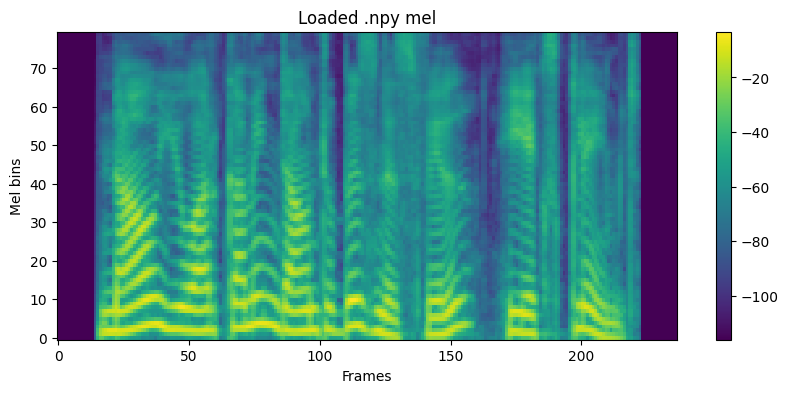

RuntimeError: stft requires the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release.

In [13]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
# Import the modified meldataset
from meldataset import mel_spectrogram
import soundfile as sf
import os

# Define the path to the meldataset.py file
meldataset_path = "/content/hifi-gan/meldataset.py"

# Read the content of the file
with open(meldataset_path, "r") as f:
    meldataset_content = f.read()

# Modify the content to add return_complex=True to torch.stft
# This assumes the line looks something like:
# spec = torch.stft(y, n_fft, hop_length=hop_size, win_length=win_size, window=hann_window[str(y.device)], center=center, pad_mode='reflect', normalized=False, onesided=True)
# We need to add return_complex=True before the closing parenthesis
modified_meldataset_content = meldataset_content.replace(
    "onesided=True)",
    "onesided=True, return_complex=True)"
)

# Write the modified content back to the file
with open(meldataset_path, "w") as f:
    f.write(modified_meldataset_content)

print(f"Modified {meldataset_path} to include return_complex=True in torch.stft.")

# match your HiFi-GAN training params
n_fft = 1024
num_mels = 80
hop_size = 256
win_size = 1024
sampling_rate = 16000
fmin = 90
fmax = 7600

# --------- Load an .npy mel (from AutoVC or preprocessing) ---------
mel = np.load("/content/spmel/female_speaker/train_hindifullfemale_00014_16k.npy")

print("Loaded .npy mel shape:", mel.shape)
print("Min/Max values:", mel.min(), mel.max())

# Ensure mel shape is (num_mels, T)
if mel.shape[0] != num_mels and mel.shape[1] == num_mels:
    mel = mel.T
    print("Transposed mel -> new shape:", mel.shape)

# Plot the .npy mel
plt.figure(figsize=(10,4))
plt.imshow(mel, aspect="auto", origin="lower", interpolation="none")
plt.colorbar()
plt.title("Loaded .npy mel")
plt.xlabel("Frames")
plt.ylabel("Mel bins")
plt.show()

# --------- Compute mel from wav ---------
wav, sr = sf.read("/content/wav16k/female_speaker/train_hindifullfemale_00014_16k.wav")
wav = torch.FloatTensor(wav).unsqueeze(0)  # (1, T)

with torch.no_grad():
    mel_from_wav = mel_spectrogram(
        wav, n_fft, num_mels, sampling_rate,
        hop_size, win_size, fmin, fmax, center=False
    ).cpu().numpy()

print("mel_from_wav shape:", mel_from_wav.shape)

# --------- Plot side by side ---------
fig, axs = plt.subplots(1, 3, figsize=(18,4))

axs[0].imshow(mel, aspect="auto", origin="lower", interpolation="none")
axs[0].set_title("Loaded .npy mel")
axs[0].set_xlabel("Frames"); axs[0].set_ylabel("Mel bins")

axs[1].imshow(mel_from_wav, aspect="auto", origin="lower", interpolation="none")
axs[1].set_title("Mel from HiFi-GAN extraction")
axs[1].set_xlabel("Frames"); axs[1].set_ylabel("Mel bins")

# Align lengths for difference plot
min_frames = min(mel.shape[1], mel_from_wav.shape[1])
diff = mel[:, :min_frames] - mel_from_wav[:, :min_frames]

im = axs[2].imshow(diff, aspect="auto", origin="lower", interpolation="none", cmap="bwr")
axs[2].set_title("Difference (npy - wav)")
axs[2].set_xlabel("Frames"); axs[2].set_ylabel("Mel bins")
fig.colorbar(im, ax=axs[2])

plt.tight_layout()
plt.show()

Loaded .npy mel shape: (237, 80)
Min/Max values: 0.0 0.9675392
Transposed mel -> new shape: (80, 237)


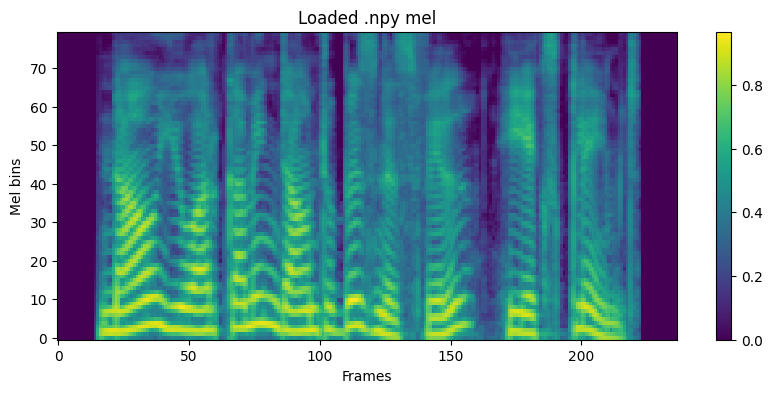

> /tmp/ipython-input-1066209590.py(31)mel_spectrogram()
     29         mel = librosa.filters.mel(sr=sampling_rate, n_fft=n_fft, n_mels=num_mels, fmin=fmin, fmax=fmax)
     30         breakpoint()
---> 31         mel_basis[str(sampling_rate)+'_'+str(n_fft)+'_'+str(num_mels)+'_'+str(fmin)+'_'+str(fmax)] = torch.FloatTensor(mel).to(device)
     32 
     33     if str(y.device) not in hann_window:

--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [24]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
import soundfile as sf
import os
from scipy.signal import get_window
from librosa.filters import mel # Explicitly import mel here

# Define the mel_spectrogram function locally with the fix
def mel_spectrogram(y, n_fft, num_mels, sampling_rate, hop_size, win_size, fmin, fmax, center=False):
    if torch.min(y) < -1.:
        print('min value is ', torch.min(y))
    if torch.max(y) > 1.:
        print('max value is ', torch.max(y))

    global mel_basis, hann_window
    if 'mel_basis' not in globals():
        mel_basis = {}
        hann_window = {}

    device = y.device
    fmax_loss = None # Assuming fmax_loss is not used in this context or set to None
    # Assuming 0 is min_level_db for power_to_db
    # Assuming 100 is ref_level_db for power_to_db

    # Ensure mel_basis is a tensor
    if str(sampling_rate)+'_'+str(n_fft)+'_'+str(num_mels)+'_'+str(fmin)+'_'+str(fmax) not in mel_basis:
        mel = librosa.filters.mel(sr=sampling_rate, n_fft=n_fft, n_mels=num_mels, fmin=fmin, fmax=fmax)
        breakpoint()
        mel_basis[str(sampling_rate)+'_'+str(n_fft)+'_'+str(num_mels)+'_'+str(fmin)+'_'+str(fmax)] = torch.FloatTensor(mel).to(device)


    if str(y.device) not in hann_window:
        hann_window[str(y.device)] = torch.hann_window(win_size).to(device)

    y = y.squeeze(1)

    # Add return_complex=True to torch.stft
    spec = torch.stft(y, n_fft, hop_length=hop_size, win_length=win_size, window=hann_window[str(y.device)],
                      center=center, pad_mode='reflect', normalized=False, onesided=True, return_complex=True)

    # Calculate magnitude spectrum, keeping the batch dimension
    spec = torch.sqrt(spec.abs().pow(2).sum(-1, keepdim=True) + (1e-9)) # magnitude spectrum

    spec = torch.matmul(mel_basis[str(sampling_rate)+'_'+str(n_fft)+'_'+str(num_mels)+'_'+str(fmin)+'_'+str(fmax)], spec)
    spec = spectral_normalize_torch(spec)

    return spec

def dynamic_range_compression_torch(x, C=1, clip_val=1e-5):
    return torch.log(torch.clamp(x, min=clip_val) * C)

def spectral_normalize_torch(magnitudes):
    output = dynamic_range_compression_torch(magnitudes)
    return output


# match your HiFi-GAN training params
n_fft = 1024
num_mels = 80
hop_size = 256
win_size = 1024
sampling_rate = 16000
fmin = 90
fmax = 7600

# --------- Load an .npy mel (from AutoVC or preprocessing) ---------
mel = np.load("/content/spmel/female_speaker/train_hindifullfemale_00014_16k.npy")

print("Loaded .npy mel shape:", mel.shape)
print("Min/Max values:", mel.min(), mel.max())

# Ensure mel shape is (num_mels, T)
if mel.shape[0] != num_mels and mel.shape[1] == num_mels:
    mel = mel.T
    print("Transposed mel -> new shape:", mel.shape)

# Plot the .npy mel
plt.figure(figsize=(10,4))
plt.imshow(mel, aspect="auto", origin="lower", interpolation="none")
plt.colorbar()
plt.title("Loaded .npy mel")
plt.xlabel("Frames")
plt.ylabel("Mel bins")
plt.show()

# --------- Compute mel from wav ---------
wav, sr = sf.read("/content/wav16k/female_speaker/train_hindifullfemale_00014_16k.wav")
wav = torch.FloatTensor(wav).unsqueeze(0)  # (1, T)

with torch.no_grad():
    # Use the locally defined mel_spectrogram function
    mel_from_wav = mel_spectrogram(
        wav, n_fft, num_mels, sampling_rate,
        hop_size, win_size, fmin, fmax, center=False
    ).cpu().numpy()

# Squeeze the extra dimension
mel_from_wav = mel_from_wav.squeeze(-1)


print("mel_from_wav shape:", mel_from_wav.shape)

# --------- Plot side by side ---------
fig, axs = plt.subplots(1, 3, figsize=(18,4))

axs[0].imshow(mel, aspect="auto", origin="lower", interpolation="none")
axs[0].set_title("Loaded .npy mel")
axs[0].set_xlabel("Frames"); axs[0].set_ylabel("Mel bins")

axs[1].imshow(mel_from_wav, aspect="auto", origin="lower", interpolation="none")
axs[1].set_title("Mel from HiFi-GAN extraction")
axs[1].set_xlabel("Frames"); axs[1].set_ylabel("Mel bins")

# Align lengths for difference plot
min_frames = min(mel.shape[1], mel_from_wav.shape[1])
diff = mel[:, :min_frames] - mel_from_wav[:, :min_frames]

im = axs[2].imshow(diff, aspect="auto", origin="lower", interpolation="none", cmap="bwr")
axs[2].set_title("Difference (npy - wav)")
axs[2].set_xlabel("Frames"); axs[2].set_ylabel("Mel bins")
fig.colorbar(im, ax=axs[2])

plt.tight_layout()
plt.show()

In [17]:
print(mel_tensor.shape)

torch.Size([1, 80, 176])


In [16]:
print (mel_converted.min(), mel_converted.max())

-0.28126606 0.81946146


In [ ]:
# Check h in checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
print(checkpoint.keys())          # see if it contains 'h' or 'config'
if 'h' in checkpoint:
    h_ckpt = checkpoint['h']
    print(vars(h_ckpt))           # compare with your h

dict_keys(['generator'])


In [18]:
import librosa
wav, sr = librosa.load(wav_path, sr=22050)
print(sr)

22050


testing the hifigan npy file alone to see if it outputs noise... will also try with an autovc mel

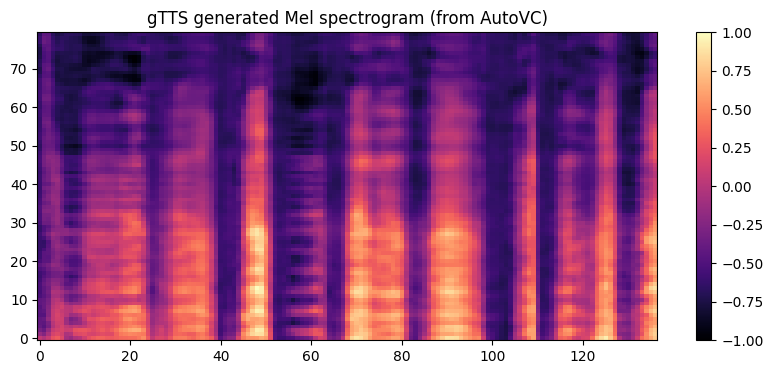

gTTS Mel range: min=-1.0, max=1.0


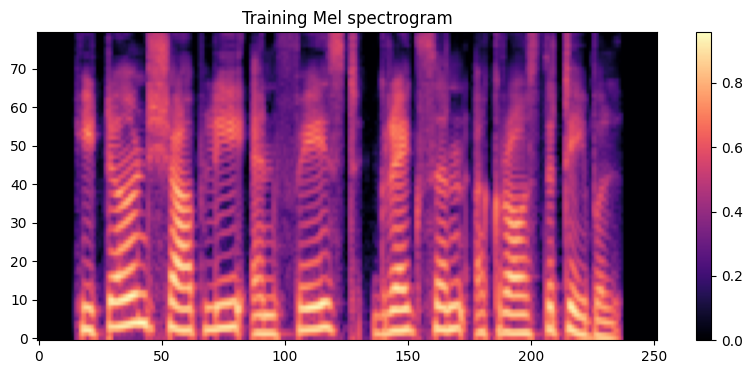

Training Mel range: min=0.0, max=0.9569480419158936


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Load a gTTS generated mel spectrogram
gtts_mel_path = "mel_files/speech1.npy"
gtts_mel = np.load(gtts_mel_path)

# Plot the gTTS mel spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(gtts_mel.T, origin='lower', aspect='auto', cmap='magma')
plt.colorbar()
plt.title("gTTS generated Mel spectrogram (from AutoVC)")
plt.show()

# Print the range of values in the gTTS mel
print(f"gTTS Mel range: min={gtts_mel.min()}, max={gtts_mel.max()}")

# Load a training mel spectrogram
training_mel_path = "/content/spmel/female_speaker/train_hindifullfemale_00009_16k.npy" # Using the same file as in your test cell
training_mel = np.load(training_mel_path)

# Plot the training mel spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(training_mel.T, origin='lower', aspect='auto', cmap='magma')
plt.colorbar()
plt.title("Training Mel spectrogram")
plt.show()

# Print the range of values in the training mel
print(f"Training Mel range: min={training_mel.min()}, max={training_mel.max()}")

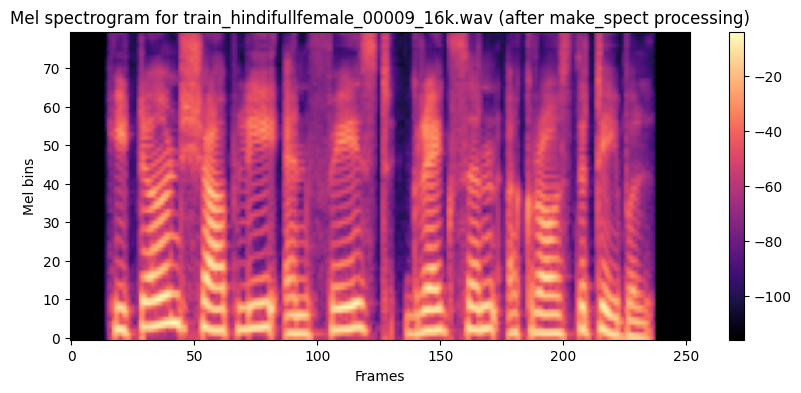

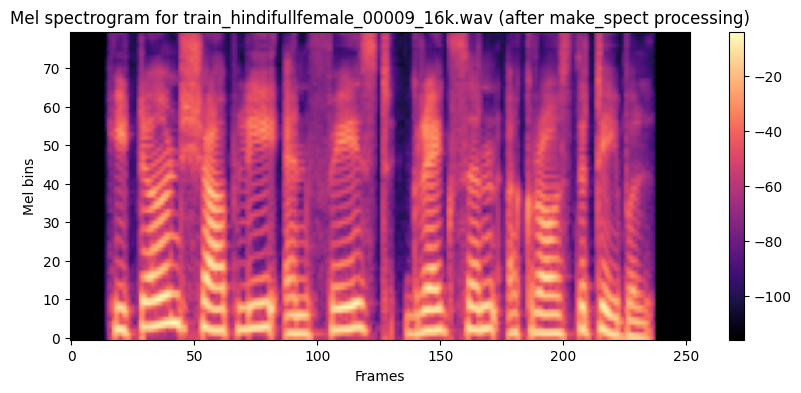

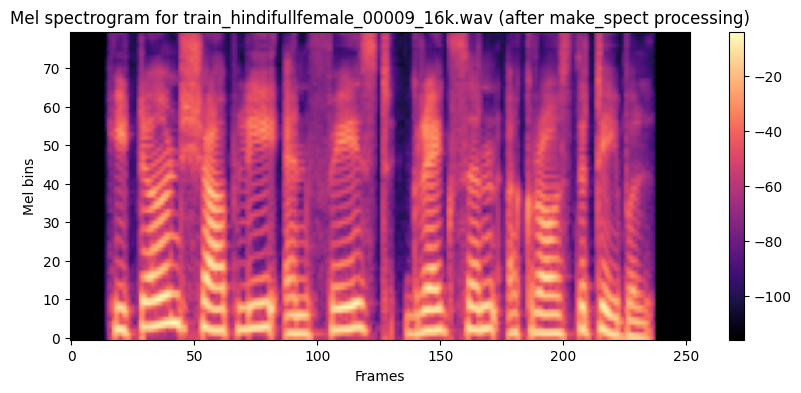

Mel spectrogram shape: (252, 80)
Mel spectrogram range: min=-116.00000000000001, max=-3.9506200900364874


In [ ]:
%matplotlib inline
import os
import numpy as np
import soundfile as sf
from scipy import signal
from scipy.signal import get_window
from librosa.filters import mel # Explicitly import mel here
from numpy.random import RandomState
import matplotlib.pyplot as plt

# --- Configuration ---
# Replace with the path to one of your clear female speaker WAV files
single_wav_path = "/content/wav16k/female_speaker/train_hindifullfemale_00009_16k.wav"

# --- Include definitions from make_spect.py ---
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

# Assuming these are the values used in your make_spect.py
b, a = butter_highpass(30, 16000, order=5)

def pySTFT(x, fft_length=1024, hop_length=256):

    x = np.pad(x, int(fft_length//2), mode='reflect')

    noverlap = fft_length - hop_length
    shape = x.shape[:-1]+((x.shape[-1]-noverlap)//hop_length, fft_length)
    strides = x.strides[:-1]+(hop_length*x.strides[-1], x.strides[-1])
    result = np.lib.stride_tricks.as_strided(x, shape=shape,
                                             strides=strides)

    fft_window = get_window('hann', fft_length, fftbins=True)
    result = np.fft.rfft(fft_window * result, n=fft_length).T

    return np.abs(result)

# Definition of mel_basis and min_level from make_spect.py
# Ensure these parameters match your training setup
sr = 16000
n_fft = 1024
fmin = 90
fmax = 7600
n_mels = 80

mel_basis = mel(sr=sr, n_fft=n_fft, fmin=fmin, fmax=fmax, n_mels=n_mels).T
min_level = np.exp(-100 / 20 * np.log(10))


# Read audio file
x, fs = sf.read(single_wav_path)

# Remove drifting noise (assuming you kept this in make_spect.py)
# If you commented out the filtering, use y = x instead
y = signal.filtfilt(b, a, x)


# Compute spect
D = pySTFT(y).T

# Convert to mel
D_mel = np.dot(D, mel_basis)

# Convert to dB scale
D_db = 20 * np.log10(np.maximum(min_level, D_mel)) - 16

# --- Visualize the mel spectrogram ---
plt.figure(figsize=(10, 4))
plt.imshow(D_db.T, origin='lower', aspect='auto', cmap='magma')
plt.colorbar()
plt.title(f"Mel spectrogram for {os.path.basename(single_wav_path)} (after make_spect processing)")
plt.xlabel("Frames")
plt.ylabel("Mel bins")
plt.show()

print(f"Mel spectrogram shape: {D_db.shape}")
print(f"Mel spectrogram range: min={D_db.min()}, max={D_db.max()}")